In [357]:
import pandas as pd
import numpy as np
import math
from numpy.random import normal, uniform
# from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import warnings
import random
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Sequential Bayesion Learning

In [358]:
ImportData = pd.read_csv("data.csv")
df = pd.DataFrame(ImportData)
df = df.sample(frac=1).reset_index(drop=True)

data = dict()
data['x'] = df['X'].values.reshape(100, 1)
data['t'] = df['T'].values.reshape(100, 1)
x = data['x'][:100]
t = data['t'][:100]

# Sigmoid Basis Function parameter
M = 3
s = 0.6

# Distribution parameter
alpha = 10E-6
beta = 1
m0 = np.zeros(M)
# S0 = alpha^-1 ‧ I
S0 = 1/alpha * np.identity(M)

In [359]:
def Sigmoid_Basis(x, j,):
  muj = (2 * j) / M
  a = (x - muj) / s
  return 1 / (1 + np.exp(-a))

def Calc_Y(w, x_axis):
  y_axis = []
  phi = np.zeros((M,1))
  for i in range(len(x_axis)):
    for j in range(M):
      phi[j] = Sigmoid_Basis(x_axis[i],j)
    y_axis.append(w.dot(phi))
  # y_axis = np.asarray(t).reshape(-1,1)
  return y_axis

In [360]:
class BayesianLinearRegression(object):
  def __init__(self, m0, S0):
    self.m0 = m0
    self.S0 = S0

    # self.prior = multivariate_normal(mean=self.m0, cov=self.S0)
    self.prior = np.random.multivariate_normal(mean=self.m0, cov=self.S0)
    self.mN = self.m0
    self.SN = self.S0
    # self.posterior = multivariate_normal(mean=self.mN, cov=self.SN)
    self.posterior = np.random.multivariate_normal(mean=self.mN, cov=self.SN)

  def Basis_Function(self, input_x):
    # Shape of input_x:(Nx1), phi:(NxM)
    phi = np.zeros((1, M))
    for j in range(M):
      phi[0][j] = Sigmoid_Basis(input_x,j)
    return phi

  def Calc_Posterior(self, input_x, target):
    # Update mN, SN given vectors x, t
    # Shape of input_x,target:(Nx1), SN:(MxM), mN:(Mx1)
    target = target.reshape(1,1)
    phi = self.Basis_Function(input_x)
    # SN = alpha ‧ I + beta ‧ PhiT ‧ Phi
    # mN = beta ‧ SN ‧ PhiT ‧ t
    # p(w|t) = N(w|mN, SN)
    self.SN = np.linalg.inv(np.linalg.inv(self.S0) + beta * phi.T.dot(phi))
    self.mN = self.SN.dot(np.linalg.inv(self.S0).dot(self.m0.reshape(M,1)) + beta * phi.T.dot(target))
    self.posterior = np.random.multivariate_normal(mean=self.mN.flatten(), cov=self.SN)
    # self.posterior = multivariate_normal(mean=self.mN, cov=self.SN)

    # Training => Use the old posterior as new prior
    self.m0 = self.mN
    self.S0 = self.SN

  def Plot_Curve(self, input_x, target, x_axis, n, N_Points):
    plt.scatter(input_x, target, alpha=0.8, c='C0')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.ylim(-2, 5)
    plt.title('Curves Sampled from Posterior Distribution using %d datapoint(s)' % n, fontsize=12)

    if n in N_Points:
      # weights = self.posterior.rvs(size=5)
      weights = np.random.multivariate_normal(self.mN.flatten(), self.SN, size=5)
      for w in weights:
        y_axis = Calc_Y(w, x_axis)
        plt.plot(x_axis, y_axis, color='orange', linewidth=1)
      # plt.savefig('Posterior Curve_' + str(n) + '_datapoint.jpg')
      plt.show()

  def Plot_Predictive_Distribution(self, input_x, target, x_axis, n, N_Points):
    MeanCurve = []
    UpperBound = []
    LowerBound = []
    
    if n in N_Points:
      for x in range(len(x_axis)):
        # mean = mN.dot(phi.T)
        phi = self.Basis_Function(x_axis[x])
        mean = phi.dot(self.mN)
        var = 1/beta + phi.dot(self.SN.dot(phi.T))
        std = np.sqrt(var)
        
        MeanCurve.append(mean)
        UpperBound.append(mean + 1 * std)
        LowerBound.append(mean - 1 * std)

      MeanCurve = np.asarray(MeanCurve).reshape(-1,)
      UpperBound = np.asarray(UpperBound).reshape(-1,)
      LowerBound = np.asarray(LowerBound).reshape(-1,)

      plt.scatter(input_x, target)
      plt.plot(x_axis, MeanCurve, color='black', linewidth=1)
      plt.plot(x_axis, UpperBound, color='C0', linewidth=1)
      plt.plot(x_axis, LowerBound, color='C0', linewidth=1)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.ylim(-2,5)

      plt.fill_between(x_axis, UpperBound, LowerBound, facecolor="red", alpha=0.3)
      plt.title('Predictive Distribution using %d datapoint(s)' % n, fontsize=12)
      # plt.savefig('pred_dist_' + str(n) + '_datapoint.jpg')
      plt.show()

  # def PDF(pos):


  def Plot_Contourf(self, x_grid, y_grid, n, N_Points):
    if n in N_Points:
      mN_2 = self.mN[0:2]
      SN_2 = self.SN[0:2, 0:2]
      Posterior_2 = np.random.multivariate_normal(mean=mN_2.flatten(), cov=SN_2)

      pos = np.empty(x_grid.shape + (2,))
      pos[:, :, 0] = x_grid
      pos[:, :, 1] = y_grid

      plt.contourf(x_grid, y_grid, Posterior_2.pdf(pos), 20)
      plt.xlabel('w0', fontsize=14)
      plt.ylabel('w1', fontsize=14)

      plt.title('Distribution for Weight Parameters using %d datapoint(s)' % n, fontsize=10)
      # plt.savefig('w0_w1 Prior Distribution' + str(n) + '_datapoint.jpg')
      plt.show()


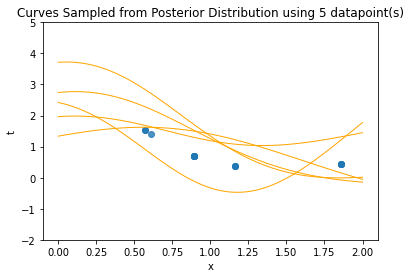

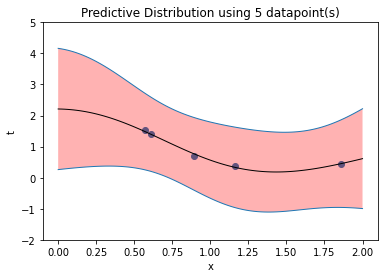

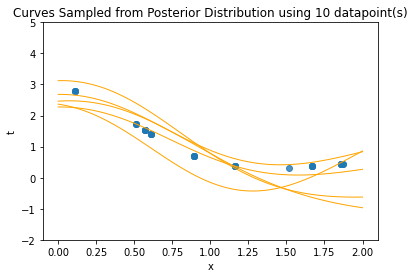

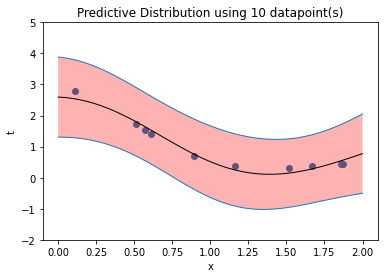

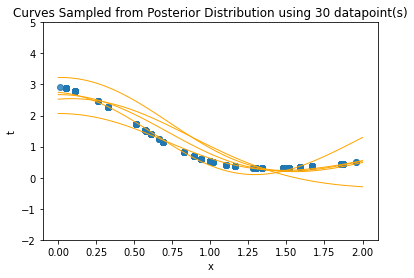

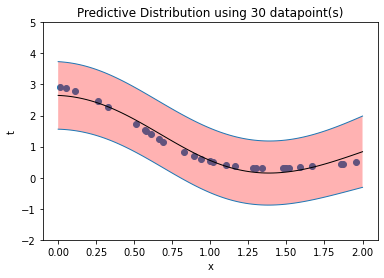

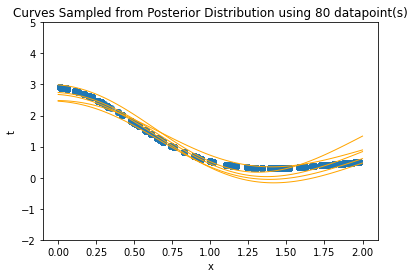

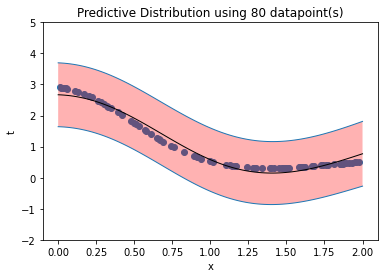

In [361]:
Model = BayesianLinearRegression(m0,S0)
N_Points = [5,10,30,80]
x_axis = np.linspace(0, 2, 100)
plot_input_x = []
plot_target = []
x_grid, y_grid = np.mgrid[-30:70:0.1, -100:40:0.1]

for n in range(1,max(N_Points)+1):
  plot_input_x.append(x[n])
  plot_target.append(t[n])
  Model.Calc_Posterior(x[n], t[n])
  Model.Plot_Curve(plot_input_x, plot_target, x_axis, n, N_Points)
  Model.Plot_Predictive_Distribution(plot_input_x, plot_target, x_axis, n, N_Points)
  # Model.Plot_Contourf(x_grid, y_grid, n, N_Points)

2. Logistic Regression

Data Preprocessing

In [362]:
# Load data
# 5 class with 64 pic in each class, shape 28 x 28
FashionDataSet = np.empty((5, 64, 28, 28))
for i in range(5):
  for j in range(64):
    FashionDataSet[i][j] = Image.open('./drive/MyDrive/Fashion_MNIST/'+ str(i)+ '/'+str(j)+'.png')
    # FashionDataSet[i][j] = Image.open('.Fashion_MNIST/'+ str(i)+ '/'+str(j)+'.png')

# Normalize all data to 0 ~ 1
for i in range(5):
  for j in range(64):
    FashionDataSet[i][j] /= 255.0

# Randomly select testing data(each class 32 pictures)
training_data = np.empty((5, 32, 28, 28))   #5 people with each 10 picture
testing_data = np.empty((5, 32, 28, 28))
training_label = np.empty((5, 32))
testing_label = np.empty((5, 32))

# to store index for each set
training_index = []
testing_index = []
for i in range(5):   # 5 class
  testing_index = random.sample([n for n in range(64)], 32)   # sample 32 pic for each class
  # print(testing_index)
  for j in range(64):
    if j not in testing_index:
      training_index.append(j)
  
  random.shuffle(training_index)
  # print(training_index)
  # Arrange data and label for training and testing set
  for k in range(32):
    training_data[i][k] = FashionDataSet[i][training_index[k]]
    training_label[i][k] = i
    testing_data[i][k] = FashionDataSet[i][testing_index[k]]
    testing_label[i][k] = i
  # reset training_index
  training_index = []
  testing_index = []


2 Logistic Regression class

In [363]:
class LogisticRegression():
  def __init__(self, input):
    # input: images with size 28x28, (0~255 => 0~1)
    # target: the label which is 5 different classes
    self.image_size = len(input.flatten())   # 784
    self.weights = np.zeros((self.image_size, 5))    # (784,5) correspond to 5 classes

  def Softmax(self, a):
    return np.exp(a) / np.sum(np.exp(a))

  def CrossEntropy(self, y, t):
    return -(np.sum(t * np.log(y)))

  def CrossEntropy_dw(self, y):
    E_dw = (self.im.dot(y - self.t))  # (784,5)
    return E_dw

  def CrossEntropy_ddw(self, y):
    # Y = np.eye(5)
    # for i in range(5):
    #   Y[i] = y[i]
    
    # Y = y.dot(np.eye(5))
    Y = y.flatten()
    E_ddw = self.im.T.dot(self.im) * np.diag(Y).dot((np.eye(5) - np.diag(y)))
    return E_ddw

  def train(self, input, target):
    
    if target == 0:
      self.t = np.array([1,0,0,0,0])
    elif target == 1:
      self.t = np.array([0,1,0,0,0])
    elif target == 2:
      self.t = np.array([0,0,1,0,0])
    elif target == 3:
      self.t = np.array([0,0,0,1,0])
    elif target == 4:
      self.t = np.array([0,0,0,0,1])

    self.im = input.flatten().reshape(-1,1)
    a = self.weights.T.dot(self.im) # (5,1)
    y = self.Softmax(a).reshape(1,-1) # (1,5)
    predict_label = np.max(y)
    
    for i in range(5):
      if predict_label == y[0][i]:
        predict_label = i
    error = self.CrossEntropy(y, self.t)

    return predict_label, y, error
  
  def Update_weight(self, E_dw, lr):
    self.weights -= lr * E_dw

  def Update_NR_weight(self, E_dw, E_ddw):
    self.weights -= np.linalg.pinv(E_ddw).dot(E_dw.T).T
  
  def Grid_Predict(self, xx, yy):
    point = np.zeros((2,1))
    point[0] = xx
    point[1] = yy
    # self.grid = grid.flatten().reshape(-1,1)
    # print('lll;l',self.weights)
    a = self.weights.T.dot(point) # (2,1)
    y = self.Softmax(a).reshape(1,-1) # (1,2)
    predict_label = np.max(y)
    for i in range(5):
      if predict_label == y[0][i]:
        predict_label = i
        # print(predict_label)
    return predict_label


2-1 Implement batch GD, SGD, mini-batch SGD (batch size = 32) and Newton-Raphson algorithms to construct a multiclass logistic
regression.

TYPE: SGD w/o PCA
epoch:  100  lr:  1e-05
Training Accuracy:  0.96875
Test Accuracy:  0.9


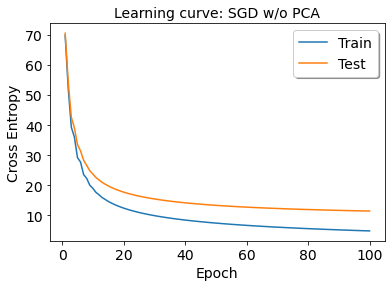

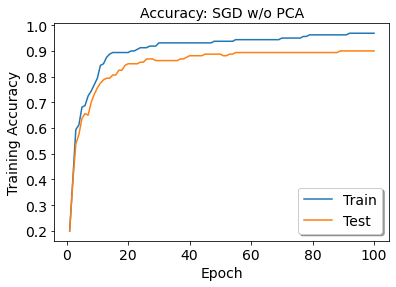

In [370]:
epochs = 100
LR = 10E-6
LRModel = LogisticRegression(training_data[0][0])
training_algorithm = "SGD"  # batchGD, SGD, mini_batchSGD, Newton_Raphson

Training_error = []
Testing_error = []
Training_accuracy = []
Testing_accuracy = []

# Batch size = N
for epoch in range(epochs):
  # print('epoch: ', epoch+1)
  TrainAccu = 0
  TestAccu = 0
  TrainLoss = 0
  TestLoss = 0
  E_dw_sum = np.zeros((784,5))
  E_ddw_sum = np.zeros((5,5))

  # Switch different training algorithms
  if training_algorithm == "batchGD":
    for i in range(5):
      for j in range(32):
        predict_label, y, error = LRModel.train(training_data[i][j], training_label[i][j])
        E_dw_sum += LRModel.CrossEntropy_dw(y)
        TrainLoss += error
        if predict_label == int(training_label[i][j]):
          TrainAccu += 1

        predict_label, y, error = LRModel.train(testing_data[i][j], testing_label[i][j])
        TestLoss += error
        if predict_label == int(testing_label[i][j]):
          TestAccu += 1

    LRModel.Update_weight((E_dw_sum), lr=LR)

  elif training_algorithm == "SGD":
    for i in range(5):
      for j in range(32):
        predict_label, y, error = LRModel.train(training_data[i][j], training_label[i][j])
        E_dw_sum += LRModel.CrossEntropy_dw(y)
        TrainLoss += error
        if predict_label == int(training_label[i][j]):
          TrainAccu += 1
        LRModel.Update_weight((E_dw_sum), lr=LR)

        predict_label, y, error = LRModel.train(testing_data[i][j], testing_label[i][j])
        TestLoss += error
        if predict_label == int(testing_label[i][j]):
          TestAccu += 1

  elif training_algorithm == "mini_batchSGD":
    for i in range(5):
      for j in range(32):
        predict_label, y, error = LRModel.train(training_data[i][j], training_label[i][j])
        E_dw_sum += LRModel.CrossEntropy_dw(y)
        TrainLoss += error
        if predict_label == int(training_label[i][j]):
          TrainAccu += 1

        predict_label, y, error = LRModel.train(testing_data[i][j], testing_label[i][j])
        TestLoss += error
        if predict_label == int(testing_label[i][j]):
          TestAccu += 1
      LRModel.Update_weight((E_dw_sum), lr=LR)

  elif training_algorithm == "Newton_Raphson":
    for i in range(5):
      for j in range(32):
        predict_label, y, error = LRModel.train(training_data[i][j], training_label[i][j])
        E_dw_sum += LRModel.CrossEntropy_dw(y)
        E_ddw_sum += LRModel.CrossEntropy_ddw(y)
        TrainLoss += error
        if predict_label == int(training_label[i][j]):
          TrainAccu += 1

        predict_label, y, error = LRModel.train(testing_data[i][j], testing_label[i][j])
        TestLoss += error
        if predict_label == int(testing_label[i][j]):
          TestAccu += 1

    LRModel.Update_NR_weight(E_dw_sum, E_ddw_sum)
  
  Training_error.append(TrainLoss/5.0)
  Training_accuracy.append(TrainAccu/160.0)
  Testing_error.append(TestLoss/5.0)
  Testing_accuracy.append(TestAccu/160.0)

  if epoch == epochs-1:
    print('TYPE: '+training_algorithm+' w/o PCA')
    print('epoch: ', epoch+1, ' lr: ', LR)
    print('Training Accuracy: ', TrainAccu/160)
    print('Test Accuracy: ', TestAccu/160)

x_axis = np.linspace(1, epochs, epochs)
Training_error = np.asarray(Training_error).reshape(-1,1)
Testing_error = np.asarray(Testing_error).reshape(-1,1)
plt.plot(x_axis, Training_error, label='Train')
plt.plot(x_axis, Testing_error, label='Test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Learning curve: '+training_algorithm+' w/o PCA', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cross Entropy', fontsize=14)
plt.legend(shadow=True, fontsize=14)
plt.show()

Training_accuracy = np.asarray(Training_accuracy).reshape(-1,1)
Testing_accuracy = np.asarray(Testing_accuracy).reshape(-1,1)
plt.plot(x_axis, Training_accuracy, label='Train')
plt.plot(x_axis, Testing_accuracy, label='Test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Accuracy: '+training_algorithm+' w/o PCA', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Accuracy', fontsize=14)
plt.legend(shadow=True, fontsize=14)
plt.show()


2-2 Use principal component analysis (PCA) to reduce the dimension of images to d = 2, 5, 10.

In [365]:
d = 2  # 2,5,10
pca_input = np.empty((160,784))

k = 0
for i in range(5):
  for j in range(32):
    pca_input[k] = training_data[i][j].flatten().reshape(1,-1)
    k += 1

mean = np.mean(pca_input, 0)
for i in range(160):
  for j in range(784):
    pca_input[i,j] = float(pca_input[i,j] - mean[j])

Cov_pca_input = np.dot(pca_input.T, pca_input)/(160-1)  # (784,784)
w, v = np.linalg.eigh(Cov_pca_input)  # w(784,1) v(784,784)
W = w[::-1]
for i in range(784):
  v[i,:] = v[i,:][::-1]
V = v[:,0:d].reshape(784,d)

Data preprocessing with PCA

In [366]:
pca_input = np.empty((160,784))
pca_test = np.empty((160,784))
training_data_pca = np.empty((160,d))
training_data_label_pca = np.empty((160,1))
testing_data_pca = np.empty((160,d))
testing_data_label_pca = np.empty((160,1))

k = 0
for i in range(5):
  for j in range(32):
    pca_input[k] = training_data[i][j].flatten().reshape(1,-1)
    pca_test[k] = testing_data[i][j].flatten().reshape(1,-1)
    training_data_label_pca[k] = training_label[i][j].flatten().reshape(1,-1)
    testing_data_label_pca[k] = testing_label[i][j].flatten().reshape(1,-1)
    k += 1

for i in range(160):
  training_data_pca[i] = pca_input[i].dot(V)
  testing_data_pca[i] = pca_test[i].dot(V)

Different training algorithm to construct a multiclass logistic
regression with PCA

TYPE: SGD w/ PCA
epoch:  200  lr:  1e-05
Training Accuracy:  0.6875
Testing Accuracy:  0.7


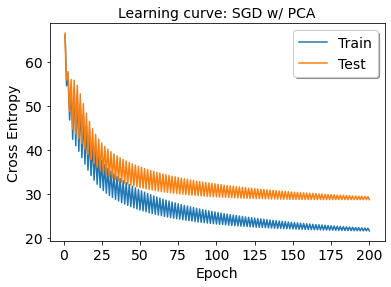

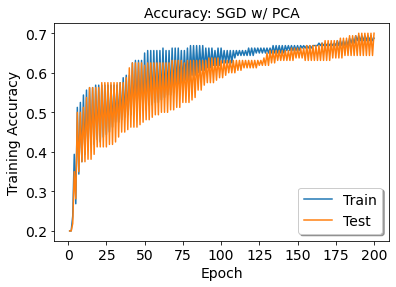

In [367]:
epochs = 200
LR = 10E-6
LRModel = LogisticRegression(training_data_pca[0])
training_algorithm = "SGD"  # batchGD, SGD, mini_batchSGD, Newton_Raphson

# one data (1,d)
# weight (d,5) 5 class

Training_error = []
Testing_error = []
Training_accuracy = []
Testing_accuracy = []

# Batch size = N
for epoch in range(epochs):
  # print('epoch: ', epoch+1)
  TrainAccu = 0
  TestAccu = 0
  TrainLoss = 0
  TestLoss = 0
  E_dw_sum = np.zeros((d,5))
  E_ddw_sum = np.zeros((5,5))

  if training_algorithm == "batchGD":
    for i in range(160):
      predict_label, y, error = LRModel.train(training_data_pca[i], training_data_label_pca[i])
      E_dw_sum += LRModel.CrossEntropy_dw(y)
      TrainLoss += error
      if predict_label == int(training_data_label_pca[i]):
        TrainAccu += 1

      predict_label, y, error = LRModel.train(testing_data_pca[i], testing_data_label_pca[i])
      TestLoss += error
      if predict_label == int(testing_data_label_pca[i]):
        TestAccu += 1

    LRModel.Update_weight((E_dw_sum), lr=LR)
  
  elif training_algorithm == "SGD":
    for i in range(160):
      predict_label, y, error = LRModel.train(training_data_pca[i], training_data_label_pca[i])
      E_dw_sum += LRModel.CrossEntropy_dw(y)
      TrainLoss += error
      if predict_label == int(training_data_label_pca[i]):
        TrainAccu += 1
      LRModel.Update_weight((E_dw_sum), lr=LR)

      predict_label, y, error = LRModel.train(testing_data_pca[i], testing_data_label_pca[i])
      TestLoss += error
      if predict_label == int(testing_data_label_pca[i]):
        TestAccu += 1

  elif training_algorithm == "mini_batchSGD":
    for i in range(160):
      predict_label, y, error = LRModel.train(training_data_pca[i], training_data_label_pca[i])
      E_dw_sum += LRModel.CrossEntropy_dw(y)
      TrainLoss += error
      if predict_label == int(training_data_label_pca[i]):
        TrainAccu += 1
      if ((i+1) % 32 == 0):
        LRModel.Update_weight((E_dw_sum), lr=LR)

      predict_label, y, error = LRModel.train(testing_data_pca[i], testing_data_label_pca[i])
      TestLoss += error
      if predict_label == int(testing_data_label_pca[i]):
        TestAccu += 1

  elif training_algorithm == "Newton_Raphson":
    for i in range(160):
      predict_label, y, error = LRModel.train(training_data_pca[i], training_data_label_pca[i])
      E_dw_sum += LRModel.CrossEntropy_dw(y)
      E_ddw_sum += LRModel.CrossEntropy_ddw(y)
      TrainLoss += error
      if predict_label == int(training_data_label_pca[i]):
        TrainAccu += 1

      predict_label, y, error = LRModel.train(testing_data_pca[i], testing_data_label_pca[i])
      TestLoss += error
      if predict_label == int(testing_data_label_pca[i]):
        TestAccu += 1

    LRModel.Update_NR_weight(E_dw_sum, E_ddw_sum)


  Training_error.append(TrainLoss/5.0)
  Training_accuracy.append(TrainAccu/160.0)
  Testing_error.append(TestLoss/5.0)
  Testing_accuracy.append(TestAccu/160.0)

  if epoch == epochs-1:
    print('TYPE: '+training_algorithm+' w/ PCA')
    print('epoch: ', epoch+1, ' lr: ', LR)
    print('Training Accuracy: ', TrainAccu/160)
    print('Testing Accuracy: ', TestAccu/160)

x_axis = np.linspace(1, epochs, epochs)
Training_error = np.asarray(Training_error).reshape(-1,1)
Testing_error = np.asarray(Testing_error).reshape(-1,1)
plt.plot(x_axis, Training_error, label='Train')
plt.plot(x_axis, Testing_error, label='Test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Learning curve: '+training_algorithm+' w/ PCA', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cross Entropy', fontsize=14)
plt.legend(shadow=True, fontsize=14)
plt.show()

Training_accuracy = np.asarray(Training_accuracy).reshape(-1,1)
Testing_accuracy = np.asarray(Testing_accuracy).reshape(-1,1)
plt.plot(x_axis, Training_accuracy, label='Train')
plt.plot(x_axis, Testing_accuracy, label='Test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Accuracy: '+training_algorithm+' w/ PCA', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Accuracy', fontsize=14)
plt.legend(shadow=True, fontsize=14)
plt.show()


2-2-b Plot d eigenvectors corresponding to top d eigenvalues

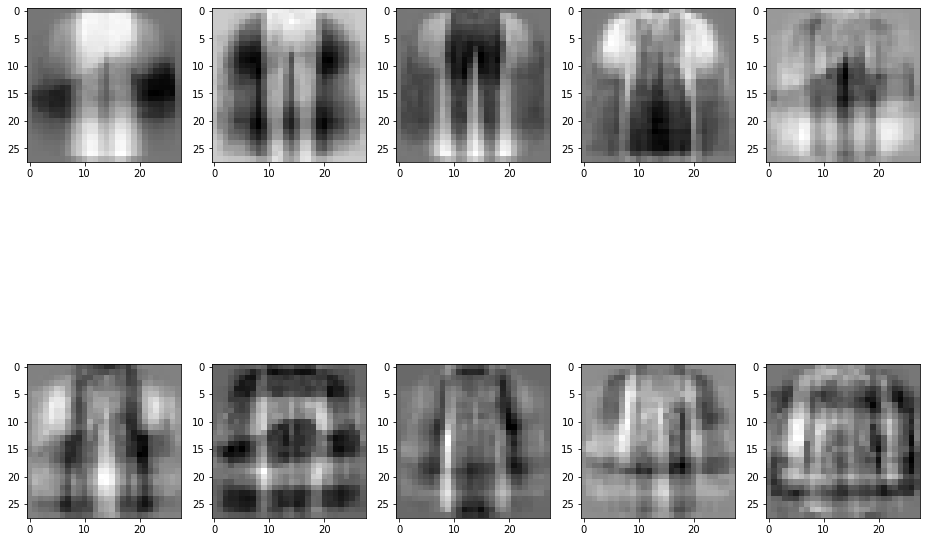

In [368]:
pca_input = np.empty((160,784))
k = 0
for i in range(5):
  for j in range(32):
    pca_input[k] = training_data[i][j].flatten().reshape(1,-1)
    k += 1

mean = np.mean(pca_input, 0)
for i in range(160):
  for j in range(784):
    pca_input[i,j] = float(pca_input[i,j] - mean[j])

Cov_pca_input = np.dot(pca_input.T, pca_input)/(160-1)  # (784,784)

w, v = np.linalg.eigh(Cov_pca_input)  # w(784,1) v(784,784)

d = 10  # 2,5,10
W = w.argsort()[-d:][::-1]
V = np.empty((d,28,28))
for i in range(d):
  V[i] = v[:,W[i]:(W[i]+1)].reshape(28,28)

fig = plt.figure(figsize=(16,12)) 
ax1 = fig.add_subplot(2,5,1)
ax2 = fig.add_subplot(2,5,2)
ax3 = fig.add_subplot(2,5,3)
ax4 = fig.add_subplot(2,5,4)
ax5 = fig.add_subplot(2,5,5)
ax6 = fig.add_subplot(2,5,6)
ax7 = fig.add_subplot(2,5,7)
ax8 = fig.add_subplot(2,5,8)
ax9 = fig.add_subplot(2,5,9)
ax10 = fig.add_subplot(2,5,10)
ax1.imshow(V[0], cmap="gray")
ax2.imshow(V[1], cmap="gray")
ax3.imshow(V[2], cmap="gray")
ax4.imshow(V[3], cmap="gray")
ax5.imshow(V[4], cmap="gray")
ax6.imshow(V[5], cmap="gray")
ax7.imshow(V[6], cmap="gray")
ax8.imshow(V[7], cmap="gray")
ax9.imshow(V[8], cmap="gray")
ax10.imshow(V[9], cmap="gray")
plt.show()

# Same function.
# w = w[::-1]
# for i in range(784):
#   v[i,:] = v[i,:][::-1]
# v1 = v[:,0:1].reshape(28,28)
# v2 = v[:,1:2].reshape(28,28)
# v3 = v[:,2:3].reshape(28,28)

# fig = plt.figure()  
# ax1 = fig.add_subplot(1,3,1) 
# ax1.imshow(v1, cmap="gray")
# ax2 = fig.add_subplot(1,3,2)  
# ax2.imshow(v2, cmap="gray") 
# ax3 = fig.add_subplot(1,3,3)  
# ax3.imshow(v3, cmap="gray") 
# plt.show()

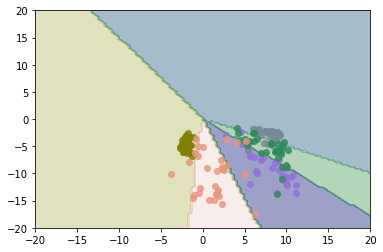

In [369]:
# Only work when d = 2
# Fixed d = 2, re-prepare the eigenvector and transform the original data again.
import itertools
NN = 100
xx = np.linspace(-20, 20, NN)
yy = np.linspace(-20, 20, NN)
x_grid, y_grid = np.meshgrid(xx,yy)
Z = np.empty(x_grid.shape)
grid = np.empty(x_grid.shape)

for i in range(NN):
  for j in range(NN):
    Z[i][j] = LRModel.Grid_Predict(xx[j],yy[i])

color = itertools.cycle(["mediumpurple","lightslategrey","seagreen","olive","darksalmon"])
plt.contourf(x_grid, y_grid, Z, cmap='gist_earth', alpha=0.4)
for i in range(5):
  plt.scatter(training_data_pca[32*i:32*i+31,0], training_data_pca[32*i:32*i+31,1], alpha=0.8, c=next(color))
  # plt.scatter(testing_data_pca[32*i:32*i+31,0], testing_data_pca[32*i:32*i+31,1],marker="x", alpha=0.8, c=next(color))   # test - train mean

plt.show()